# Empirical Dynamic Modeling with Machine Learning

**Advanced Computational Systems**  
_Kevin Siswandi_  
Biological Information Processing Group  

This notebook will walk you through the process of discovering dynamics from data. To do this, we will make use of a synthetic dataset (virtual strains) that were generated to mimic strains of engineered *E. Coli* for Limonene production. The general outline is:
1. Data Analysis
2. Creation of training data + data augmentation
3. Pipeline building and model training
4. Error analysis (derivative and integrated dynamics)

Prerequisites:
- install data science and scientific computing stack: `pandas`, `numpy`, and `scipy`
- download the dataset `limonene_train.csv` and `limonene_test.csv`
- install visualization tools: `seaborn` and `matplotlib`
- install machine learning libraries: `sklearn`, `tpot`

Parts that you need to complete are marked with `#TODO`. For more information regarding the dataset and methods, see:
* [Weaver et al., 2015](https://pubmed.ncbi.nlm.nih.gov/24981116/) in Wiley Biotechnology and Bioengineering
* [Costello & Martin, 2018](https://www.nature.com/articles/s41540-018-0054-3) in npj Systems Biology and Applications

In [2]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
import seaborn as sns
print(sns.__version__)

0.9.0


## Data Analysis

The first step is to load the data and take a look at some of its basic properties. Answer the following questions:

**Questions**:
1. How many test and training strains are there in the dataset?
2. For each strain, how many time points are there?
3. How many variables are there in the dataset?

In [23]:
# TODO: change the path to where you save the dataset
train_data = pd.read_csv('data/limonene_train.csv')
test_data = pd.read_csv('data/limonene_test.csv')

# TODO: exploratory data analysis
# how many strains are there in the training data and test data
# how many time points are there for each strain

## YOUR CODE HERE



# display the first 5 rows
train_data.head()

Strain  Hour  Acetoacetyl-CoA  Acetyl-CoA          AtoB     DMAPP  \
0      29     0         0.199557    0.198079  1.858473e+00  0.198722   
1      29     1         0.201162    0.201651  9.431596e+05  0.200381   
2      29     2         0.200564    0.203859  1.043809e+06  0.198287   
3      29     3         0.202230    0.205377  1.082836e+06  0.199639   
4      29     4         0.200126    0.205699  1.090019e+06  0.198554   

        GPP          GPPS   HMG-CoA          HMGR  ...       IPP  \
0  0.199553  5.535782e+00  0.198736  1.522973e+00  ...  0.200827   
1  0.196530  2.225341e+06  0.198629  2.812445e+06  ...  0.212604   
2  0.199416  2.609550e+06  0.197531  3.692984e+06  ...  0.223816   
3  0.196272  2.756969e+06  0.197077  4.159503e+06  ...  0.232580   
4  0.199275  2.849823e+06  0.196725  4.427533e+06  ...  0.244459   

            Idi            LS  Limonene            MK       Mev      MevP  \
0  2.218772e+00  1.099337e+00  0.000000  6.266968e+00  0.198983  0.198526   
1  3.581406e+06  4.714061e+06  0.000347  2.398923e+06  0.199783  0.199045   
2  4.453397e+06  5.458947e+06  0.000888  3.197269e+06  0.200810  0.198048   
3  4.803963e+06  5.762519e+06  0.001470  3.564438e+06  0.199004  0.193576   
4  5.053474e+06  5.984190e+06  0.002091  3.816076e+06  0.201563  0.195600   

      MevPP           PMD           PMK  
0  0.196970  2.291591e+00  8.861631e+00  
1  0.191865  4.195782e+06  6.082258e+06  
2  0.181571  4.618850e+06  7.454398e+06  
3  0.172487  4.762293e+06  8.142833e+06  
4  0.161975  4.838369e+06  8.530366e+06  

[5 rows x 21 columns]

In the following, we will investigate the distribution of the data by generating some plots. 

**Question**: Do the proteins/enzymes possess the same distribution? To answer this question, you can use `distplot(...)` from seaborn to plot the distribution of every enzyme.

AtoB


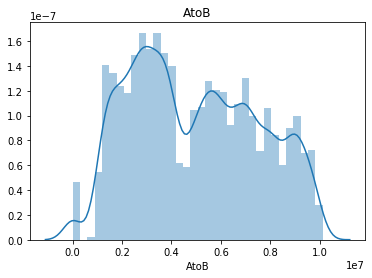

HMGR


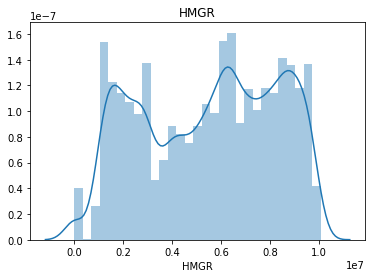

HMGS


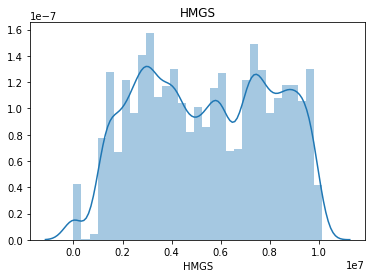

MK


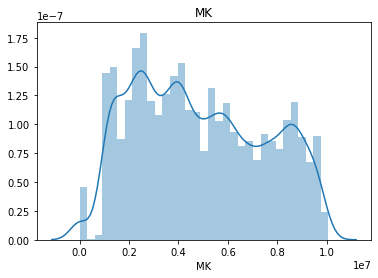

PMK


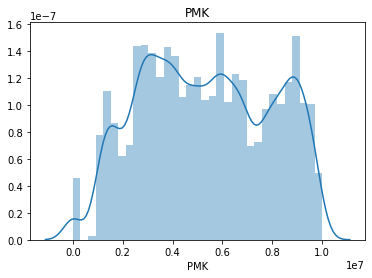

PMD


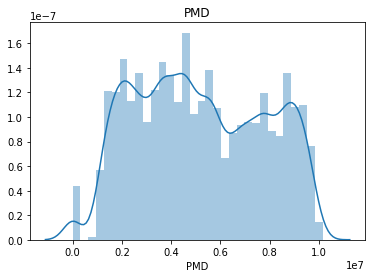

Idi


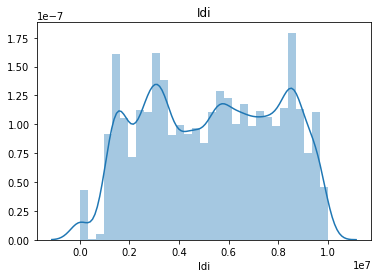

GPPS


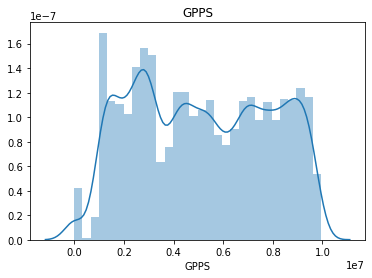

LS


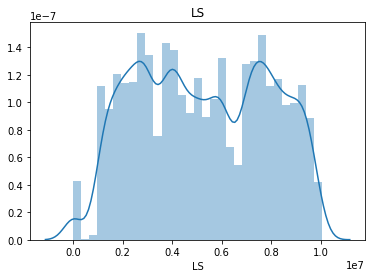

In [4]:
# list of metabolites as targets
targets = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA','Mev','MevP','MevPP','IPP','DMAPP','GPP','Limonene']

# list of enzymes as features
features = ['AtoB','HMGR','HMGS','MK','PMK','PMD','Idi','GPPS','LS']

# TODO: plot the distribution of every protein

## YOUR CODE HERE
for feature in features:
    print(feature)
    sns.distplot(train_data[feature])
    plt.title(feature)
    plt.show()

In the dataset, the metabolites are generated from the same initial condition (0.2), except Limonene, which has initial condition of zero. This choice is typical of bioengineering because the objective is to get Limonene as the useful product (as biofuel). The metabolite concentrations are obtained by solving a Michaelis-Menten based system of Ordinary Differential Equations with the initial conditions as mentioned.

**Question**: create a trace plot of every metabolite, using `tsplot` from seaborn.


Index(['Acetoacetyl-CoA', 'Acetyl-CoA', 'AtoB', 'DMAPP', 'GPP', 'GPPS',
       'HMG-CoA', 'HMGR', 'HMGS', 'IPP', 'Idi', 'LS', 'Limonene', 'MK', 'Mev',
       'MevP', 'MevPP', 'PMD', 'PMK'],
      dtype='object')


/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


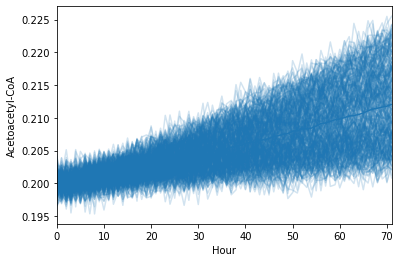

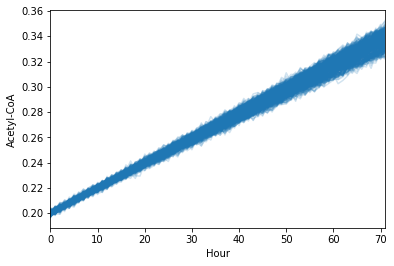

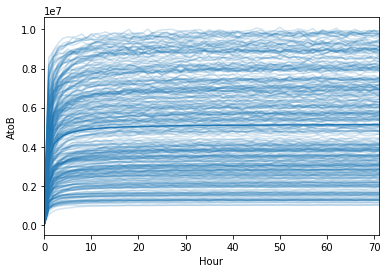

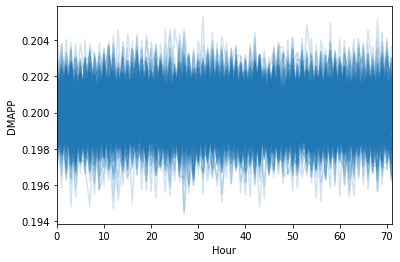

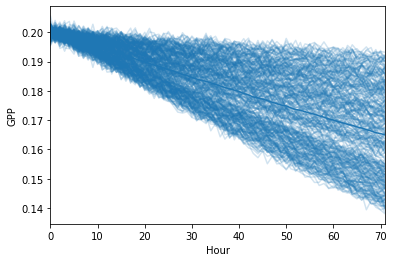

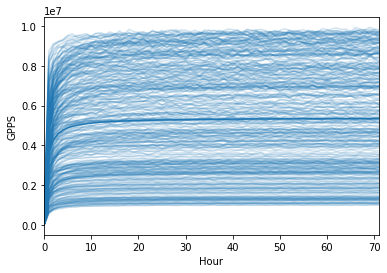

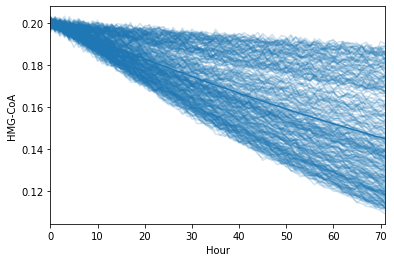

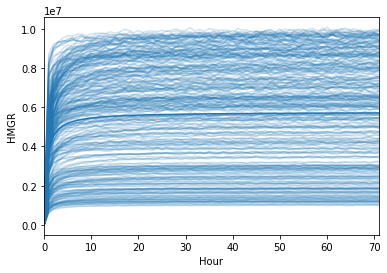

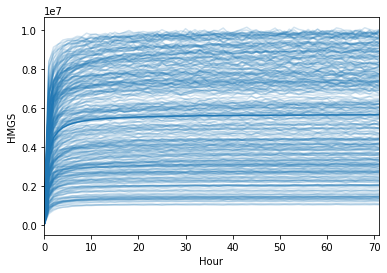

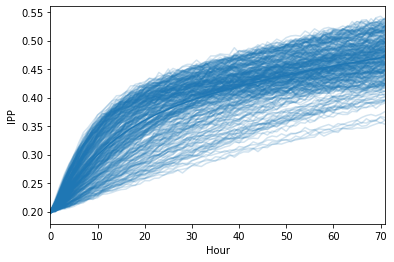

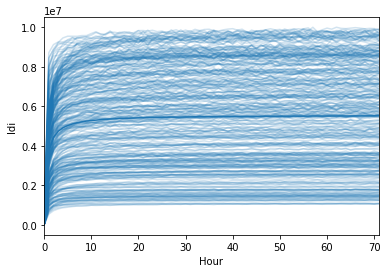

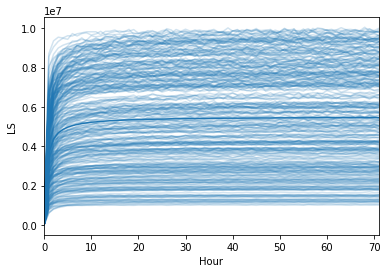

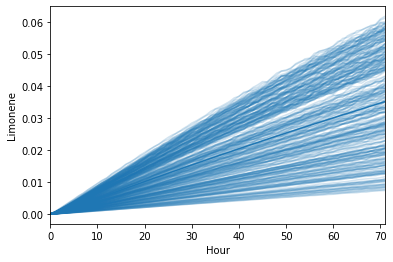

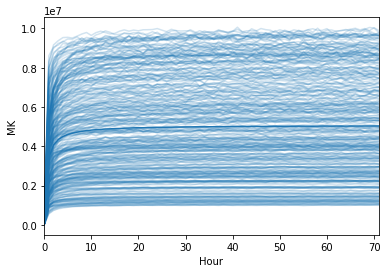

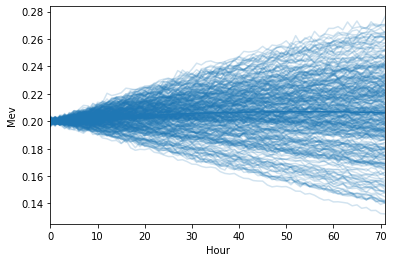

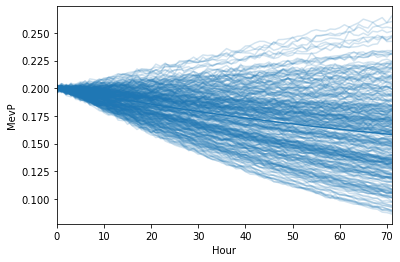

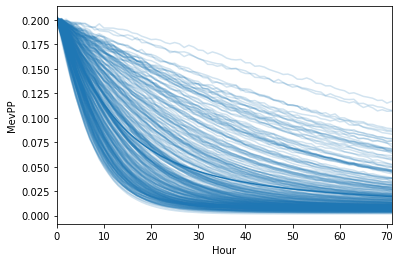

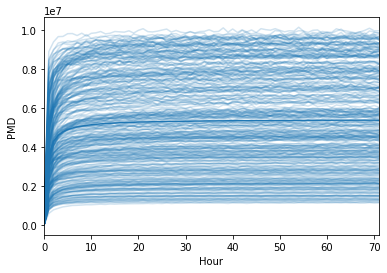

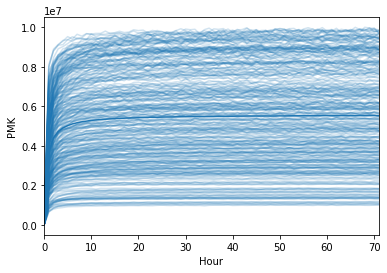

In [5]:
# TODO: plot the distribution or time-series (with uncertainty) of the metabolites

## YOUR CODE HERE
species = train_data.columns[2:]
print(species)
for element in species:
    sns.tsplot(train_data,time='Hour',unit='Strain',value=element,err_style='unit_traces')
    plt.show()

## Data Augmentation

As the first step, we will transform the data that you've just looked at into a form that is suitable for training machine learning models for learning dynamics. In the cell below, you will implement a function for generating dataset that can be used for training a model to learn dynamics. In addition, this function will also artificially create additional data points for training (i.e. data augmentation). This consists of the following steps:
1. smoothing the noisy time-series data
2. filtering the smoothed data to obtain interpolated measurements
3. computing the derivatives numerically at the interpolated points

Steps 1-2 are also data augmentation procedure for getting sufficient training data, while step 3 creates the target/output for the machine learning model. **Your task** is to complete the `generate_dataset(...)` function below, taking into account the following:
* computation of the time step for interpolation -- to generate 100 data points between start and end time, what is the time step needed between every time point?
* use `np.linspace` to generate the (e.g. 100, more generally `n_dim`) data points between start time and end time.
* apply `savgol_filter` to the interpolated points
* compute the gradients of the metabolites numerically using `np.gradient`.
* create a multi-index dataframe -- filtered data as features and computed gradients as targets

In [6]:
## TODO: write a function to create and augment the training data

def generate_dataset(data, strain_list, feature_list, target_list, n_dim):
    
    """
    Generate and augment the training data {X, y} for model fitting, using savgol filter as the smoothing method.
    
    Arguments:
    
    data -- time-series data frame of measurements, with 'Strain' as the index
    strain_list -- list of unique strains in `data`
    feature_list -- list of features to be used
    target_list -- list of targets
    n_dim -- number of data points to generate via interpolation
    
    Returns:
    ml_data -- a pandas multi-index dataframe containing features x and targets y.
    
    """
    
    ml_data = pd.DataFrame()
    
    for strain in strain_list:
        measurement_data = {}

        # Interpolate -> Filter -> Add to the table
        for measurement in feature_list + target_list:

            # extract measurement for the specific strain
            measurement_series = data.loc[strain][measurement]
            T = data.loc[strain]['Hour'] # series of time points
            
            ## TODO: extract the start time and end time and the time step
            minT,maxT = min(T),max(T) # start time and end time
            delT = (maxT - minT)/n_dim # time step for interpolation
        
            # Interpolate data
            interpolation = interp1d(T,
                                     measurement_series.tolist(),
                                     kind='linear')
            
            # TODO: generate time points to interpolate over using np.linspace
            time_points = np.linspace(minT,maxT,n_dim)
            
            # Consider the interpolated data over time
            interpolated_measurement = interpolation(time_points)
            
            # TODO: apply savgol filter to interpolated measurement, using window length of 7 and polyorder of 2
            filtered_measurement = savgol_filter(interpolated_measurement,
                                                 window_length=7,
                                                 polyorder=2)

            # TODO: fill in the data to a multi-index data frame
            if measurement in feature_list:
                # use the filtered measurement of this enzyme as features
                measurement_data[('feature',measurement)] = filtered_measurement # YOUR CODE HERE
            if measurement in target_list:
                # use the filtered measurment of this metabolite as a feature
                measurement_data[('feature',measurement)] = filtered_measurement # YOUR CODE HERE
                # additionally compute gradients of the filtered measurement and use it as target
                measurement_data[('target',measurement)] = np.gradient([point/delT for point in filtered_measurement]) # YOUR CODE HERE
   
        # Create a table
        strain_data = pd.DataFrame(measurement_data,
                                   index=pd.MultiIndex.from_product([[strain],np.linspace(minT,maxT,n_dim)],
                                   names=['Strain', 'Time']))
        ml_data = pd.concat([ml_data,strain_data])
        
    return ml_data


In our case, we assume that the system is described by the autonomous ordinary differential equation:

$$ \dot{m} = f(m, p)$$

where m is the vector of metabolite concentrations and p is the vector of protein concentrations. Now, our goal is to train a model to learn the dynamics $f$, instead of constructing a system of ODEs from knowledge of the pathway mechanisms. This can be done by training a machine learning model using the metabolite and protein concentrations as features and the derivatives as the targets. To do this, we will apply the `generate_dataset(...)` function above to create training data that consists of pairs of features and targets (derivatives).

In [24]:
# make sure that the dataframe is indexed by the strain
train_data = train_data.set_index('Strain')
test_data = test_data.set_index("Strain")

To test if your implementation is correct, run the function `generate_dataset(...)` that you have written above using the dataset provided. Note that you need to extract the strain list (both for training and test data) from the original data frame.

**HINT**: every strain is identified with a number in the 'Strain' column.

In [8]:
# TODO: extract training and test strains
te_strains = list(test_data.index.get_level_values(0).unique())
tr_strains = list(train_data.index.get_level_values(0).unique())

# TODO: apply the function above to create the training and test data
# choose an appropriate data points to generate (recommended: 200)
n_augmentation = 200
ml_train = generate_dataset(train_data, tr_strains, features,targets,n_augmentation)
ml_test = generate_dataset(test_data, te_strains, features,targets,n_augmentation)

In [9]:
## uncomment to check the generated training dataset

# display(ml_train)
display(ml_test)

feature                                            \
                          AtoB          HMGR          HMGS            MK   
Strain Time                                                                
8      0.000000  -3.507552e+04 -6.626928e+04 -2.618162e+04 -5.619402e+04   
       0.356784   1.174541e+06  2.316161e+06  9.394788e+05  1.914336e+06   
       0.713568   2.124949e+06  4.235015e+06  1.729201e+06  3.520897e+06   
       1.070352   2.816146e+06  5.690292e+06  2.342984e+06  4.763489e+06   
       1.427136   3.217174e+06  6.636226e+06  2.766257e+06  5.617469e+06   
...                        ...           ...           ...           ...   
9972   69.572864  8.866222e+06  3.637150e+06  6.638729e+06  1.732387e+06   
       69.929648  8.902292e+06  3.626731e+06  6.647979e+06  1.736531e+06   
       70.286432  8.901015e+06  3.622931e+06  6.666489e+06  1.738754e+06   
       70.643216  8.878399e+06  3.622692e+06  6.692907e+06  1.740670e+06   
       71.000000  8.834443e+06  3.626014e+06  6.727234e+06  1.742278e+06   

                                                                          \
                           PMK           PMD           Idi          GPPS   
Strain Time                                                                
8      0.000000  -1.526779e+04 -6.239893e+04 -3.164330e+04 -3.666995e+04   
       0.356784   5.257156e+05  1.976069e+06  1.139845e+06  1.303145e+06   
       0.713568   9.550812e+05  3.563270e+06  2.106556e+06  2.401220e+06   
       1.070352   1.272829e+06  4.699205e+06  2.868489e+06  3.257555e+06   
       1.427136   1.466070e+06  5.333569e+06  3.411873e+06  3.854023e+06   
...                        ...           ...           ...           ...   
9972   69.572864  5.525655e+06  4.937505e+06  7.144922e+06  2.443138e+06   
       69.929648  5.511785e+06  4.941652e+06  7.141230e+06  2.455202e+06   
       70.286432  5.525418e+06  4.935872e+06  7.143005e+06  2.455518e+06   
       70.643216  5.558596e+06  4.919909e+06  7.145754e+06  2.447915e+06   
       71.000000  5.611319e+06  4.893761e+06  7.149476e+06  2.432395e+06   

                                           ...              target   feature  \
                            LS Acetyl-CoA  ...     MevPP     MevPP       IPP   
Strain Time                                ...                                 
8      0.000000  -2.558288e+04   0.199730  ...  0.200899 -0.012361  0.198618   
       0.356784   8.743913e+05   0.199625  ...  0.196511 -0.012524  0.203490   
       0.713568   1.608127e+06   0.199973  ...  0.192007 -0.012851  0.208286   
       1.070352   2.175624e+06   0.200774  ...  0.187387 -0.013219  0.213005   
       1.427136   2.565412e+06   0.202305  ...  0.182622 -0.013554  0.217613   
...                        ...        ...  ...       ...       ...       ...   
9972   69.572864  7.773537e+06   0.326635  ...  0.010799 -0.000096  0.475699   
       69.929648  7.771445e+06   0.327535  ...  0.010766 -0.000097  0.476528   
       70.286432  7.773399e+06   0.328870  ...  0.010730 -0.000103  0.476925   
       70.643216  7.776100e+06   0.330482  ...  0.010693 -0.000106  0.476951   
       71.000000  7.779548e+06   0.332372  ...  0.010655 -0.000107  0.476605   

                    target   feature    target   feature    target   feature  \
                       IPP     DMAPP     DMAPP       GPP       GPP  Limonene   
Strain Time                                                                    
8      0.000000   0.013724  0.201960 -0.000952  0.197964  0.002029  0.000002   
       0.356784   0.013616  0.201622 -0.000836  0.198685  0.001881  0.000050   
       0.713568   0.013401  0.201366 -0.000604  0.199300  0.001585  0.000110   
       1.070352   0.013137  0.201193 -0.000241  0.199810  0.001255  0.000184   
       1.427136   0.012926  0.201195 -0.000044  0.200191  0.000950  0.000271   
...                    ...       ...       ...       ...       ...       ...   
9972   69.572864  0.002818  0.199366  0.001736  0.15

## Manual Model Building

By now, you have read in the dataset, performed some EDA and created a suitable training data. Now, let's see how we can learn dynamics from the data. The easiest way to do this is to simply train a TPOT model, which will automate all the process (see below). However, let's first build a manual pipeline and then use TPOT afterwards. We will use three representative classes of machine learning models:
1. Random Forest
2. Neural Network
3. Linear Regression

For every model, there would be slightly different preprocessing steps needed (this will be automated by TPOT later). When building a manual pipeline, you can use `Pipeline(...)` from `sklearn`. You need to complete the following.
+ create a random forest regressor with a sufficient number of estimators (e.g. 20)
+ create a pipeline consisting of:
    - standard scaling
    - a linear regressor that is bagged to improve fit. Use `BaggingRegressor(...)` with ridge regression as the base estimator.
+ create a pipelinne consiting of:
    - standard scaling
    - a neural network (multi-layer perceptron) regressor. Use `MLPRegressor(...)` with 4 hidden layers (each of size 5), adam solver, tanh activation, and adaptive learning rate.
    
If some of the terms above are unfamiliar to you, check out the following readings:
* [standard scaling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) -- centering mean to zero and scaling to unit variance
* [bagging](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html): bootstrap aggregation -- training multiple classifiers on datasets generated from the same (bootstrapped) distribution and aggregating them afterwards
* [ridge regression](https://en.wikipedia.org/wiki/Tikhonov_regularization) -- linear regression with L2 regularization
* [Adam optimization](https://arxiv.org/abs/1412.6980)
* [adaptive learning rate](https://wiki.tum.de/display/lfdv/Adaptive+Learning+Rate+Method)

In [10]:
# the features are the multi-dimensional time-series concentrations
# the target is the derivative of the dynamics

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

# TODO: create a random forest model with 20 estimators
rf_model = RandomForestRegressor(n_estimators=20)

# TODO: create a pipeline consisting of: standard scaling of the data + ridge regression
lr_model = Pipeline([('Scaler',StandardScaler()),
                            ('Linear Regressor',BaggingRegressor(base_estimator=Ridge(),
                                                                 n_estimators=20, max_samples=.8,
                                                                 bootstrap=False,
                                                                 bootstrap_features=False,
                                                                 random_state=None))])

# TODO: create a pipeline 
nn_model = Pipeline([('Scaler',StandardScaler()),
                            ('neural_net',MLPRegressor(hidden_layer_sizes=(5,5,5,5),
                                                       learning_rate_init=0.1,
                                                       learning_rate='adaptive',
                                                       solver='adam',
                                                       activation='tanh',
                                                       max_iter=1000))])

Each model is trained using inputs as follows:
- the features are the multi-dimensional time-series concentrations
- the target is the derivative of the dynamics

Here, the target variables are the derivatives of the metabolites in the reaction. We are going to implement this in such a way so that each target variable is trained with a distinct model. To achieve this, it's important to clone the model passed in to the function with `clone` function. In the next cell, **your task** will be to create a function that will:
* perform the training process for the models that we specify
* return two dictionaries:
    - a dictionary containing a trained model for every target variable
    - a dictonary containing the cross-validation score for each target
* optionally save the cross-validation plot to file

**Tips**: When executing `train_data(..)`, make sure to specify a figure path and create the directory if it doesn't exist. Otherwise, there will be an error returned! This is important because the training takes a long time to run.

In [11]:
## TODO: write a function that performs training
from sklearn.base import clone
from sklearn.model_selection import ShuffleSplit

figure_path = './plots/'

def train_data(data,model,plot=False,model_type=None):
    
    """
    Train the input data {X, y}.
    
    Arguments:
    
    data -- multi-index dataframe of time-series measurements, preprocessed by interpolating and filtering
    model -- a selected machine learning model
    plot -- decide to plot the result or not
    model_type -- determine the input model
    
    Returns:
    model_dict -- a trained model dictionary for each target
    score_dict -- a training score dictionary or each target
    
    """
            
    model_dict = {}
    score_dict = {}

    avg_score = 0
    n = 0

    for target_idx in data.columns:
    
        # All we want to train are targets
        if target_idx[0] == 'feature':
            continue
        target = target_idx[1]
        
        # TODO: create the data matrix X and the target vector y
        X = data['feature'].values.tolist() # YOUR CODE HERE
        y = data[target_idx].values.tolist() # YOUR CODE HERE
        
        if model_type == 'tpot':
            X = np.array(X)
            y = np.array(y)
        
        # TODO: train the model
        # IMPORTANT: clone the model to train a different one for each target
        if model_type == 'tpot':
            # if TPOT, use the best pipeline found
            model_dict[target] = clone(model).fit(X,y).fitted_pipeline_ # YOUR CODE HERE
        else:
            # if RF/NN/LR, simply fit X and y
            model_dict[target] = clone(model).fit(X,y) # YOUR CODE HERE
        
        # Plot results, if required
        if plot:
            
            # The training_plot function is defined below for you to complete
            CV_plot = training_plot(model_dict[target],
                                    target,X,y,
                                    cv=ShuffleSplit())
            
            axis = plt.gca()
            axis.set_ylim([-0.1, 1.1])
            
            strip_target = ''.join([char for char in target if char != '/'])
            print(strip_target)
            
            CV_plot.savefig(figure_path + strip_target + '_' + model_type + '_CV_plot.pdf',transparent=False)
            
            plt.show()
    
        # TODO: evaluate the model score
        # Every model in sklearn API has its own default scoring metric (see the respective docs), but can be easily accesed via the score method
        score = model_dict[target].score(X,y) ## YOUR CODE HERE
            
        print('Target: {}, CV Pearson R2 coefficient: {:f}'.format(target,score))
        score_dict[target] = score
    
    # TODO: compute the average score over all targets
    avg_score = sum(score_dict.values())/len(score_dict.values()) #YOUR CODE HERE
    print('Average training score:', avg_score)
    
    return model_dict,score_dict

In [12]:
# TODO: complete the function to plot training curves below
from sklearn.model_selection import learning_curve

def training_plot(estimator,title,X,y,
                  cv=None,n_jobs=1, 
                  train_sizes=np.linspace(.1, 1.0, 5)):
    
    """
    Generate a plot in training process.

    Arguements:
    
    estimator -- a machine learning model.
    title -- a title for the chart.
    X -- array of features.
    y -- target array corresponded to X.
    cv -- a cross-validation generator.
    n_jobs : a number of jobs to run in parallel.
    
    Return:
    plt -- a desired plot.
    
    """
    
    plt.figure()
    plt.title(title)
        
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    # TODO: call the learning_curve function to get scores for different training sizes
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs) # YOUR CODE HERE
    
    # TODO: compute the mean and standard deviation of the scores
    train_scores_mean = np.mean(train_scores, axis=1) #YOUR CODE HERE
    train_scores_std = np.std(train_scores, axis=1) #YOUR CODE HERE
    
    test_scores_mean = np.mean(test_scores, axis=1) #YOUR CODE HERE
    test_scores_std = np.std(test_scores, axis=1) #YOUR CODE HERE
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


## Automated Model Building

Now, let's automate the machine learning pipeline with TPOT. TPOT finds the best pipeline with programming and cross-validation: it will automate the most tedious part of machine learning by exploring several possible pipelines to find the best one for the specific dataset:

![An example Machine Learning pipeline](https://raw.githubusercontent.com/EpistasisLab/tpot/master/images/tpot-ml-pipeline.png)

Once TPOT is finished searching (or you get tired of waiting), it returns the best scikit-learn pipeline it found so you can tinker with the pipeline from there.

![An example TPOT pipeline](https://raw.githubusercontent.com/EpistasisLab/tpot/master/images/tpot-pipeline-example.png)

All images above are courtesy of [Epistasis Lab](https://github.com/EpistasisLab/tpot). More Hints:
- If you need a config dict, take a look at https://github.com/EpistasisLab/tpot/blob/master/tpot/config/regressor.py
- specify a max time limit of 30 minutes to avoid the algorithm running for too long
- use `ShuffleSplit` from scikit-learn for the cross validation method

In [23]:
from tpot import TPOTRegressor
from source.tpot_config import tpot_config_dict

# TODO: create a TPOT regressor
tpot_model = TPOTRegressor(generations=12, 
                            population_size=30, 
                            verbosity=2,
                            cv=ShuffleSplit(),
                            n_jobs=1,
                            max_time_mins=30,
                            config_dict=tpot_config_dict)

Acetyl-CoA


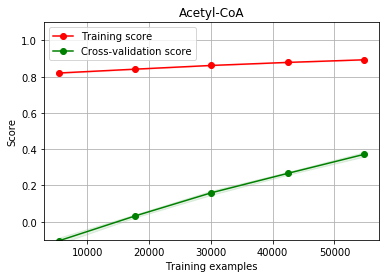

Target: Acetyl-CoA, CV Pearson R2 coefficient: 0.900355
Acetoacetyl-CoA


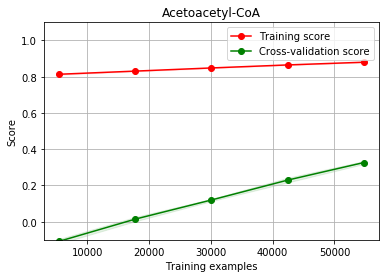

Target: Acetoacetyl-CoA, CV Pearson R2 coefficient: 0.886058
HMG-CoA


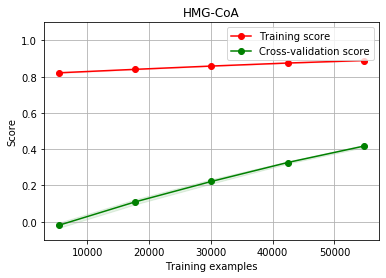

Target: HMG-CoA, CV Pearson R2 coefficient: 0.895939
Mev


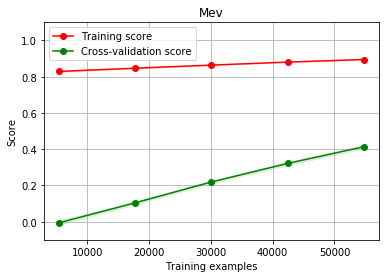

Target: Mev, CV Pearson R2 coefficient: 0.901849
MevP


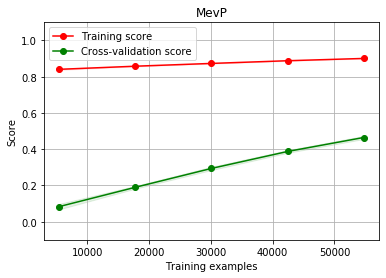

Target: MevP, CV Pearson R2 coefficient: 0.907561
MevPP


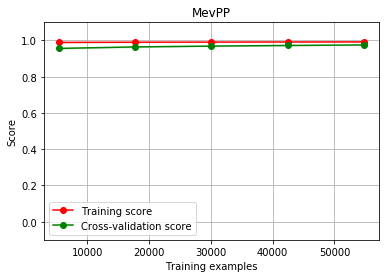

Target: MevPP, CV Pearson R2 coefficient: 0.992413
IPP


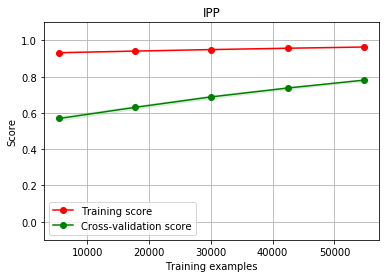

Target: IPP, CV Pearson R2 coefficient: 0.966697
DMAPP


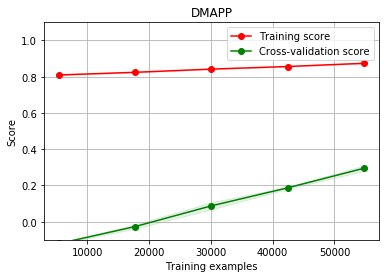

Target: DMAPP, CV Pearson R2 coefficient: 0.877460
GPP


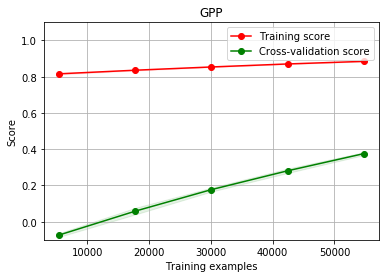

Target: GPP, CV Pearson R2 coefficient: 0.891157
Limonene


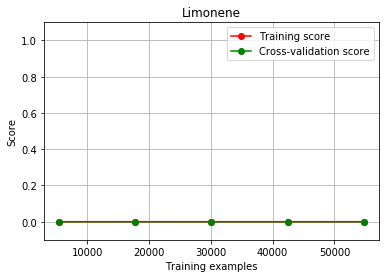

Target: Limonene, CV Pearson R2 coefficient: -0.000000
Average training score: 0.8219487901636384


In [19]:
# TODO: call the train_data function to train a random forest model (may take ~15 mins to compute)

model_type = 'random_forest'
rf_dict, score_dict = train_data(ml_train, rf_model, plot=True,model_type=model_type) # YOUR CODE HERE

Acetyl-CoA


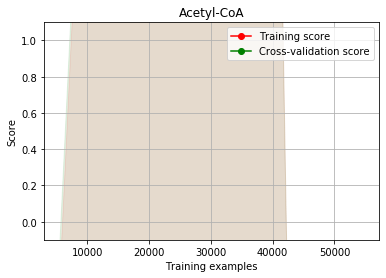

Target: Acetyl-CoA, CV Pearson R2 coefficient: -0.060356
Acetoacetyl-CoA


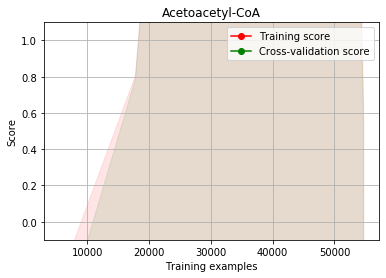

Target: Acetoacetyl-CoA, CV Pearson R2 coefficient: -3.095408
HMG-CoA


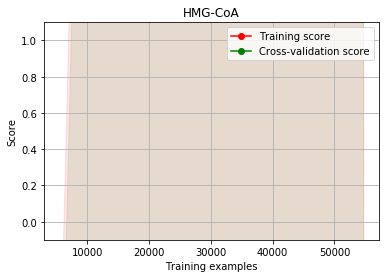

Target: HMG-CoA, CV Pearson R2 coefficient: -1.121368
Mev


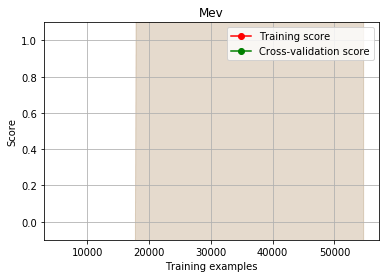

Target: Mev, CV Pearson R2 coefficient: -0.065242
MevP


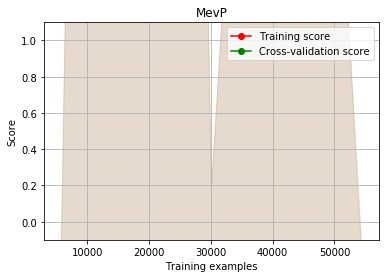

Target: MevP, CV Pearson R2 coefficient: -258.268372
MevPP


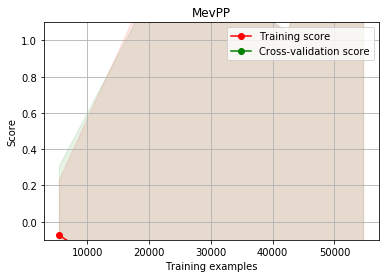

Target: MevPP, CV Pearson R2 coefficient: 0.302116
IPP


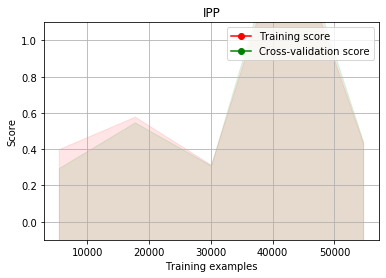

Target: IPP, CV Pearson R2 coefficient: 0.414400
DMAPP


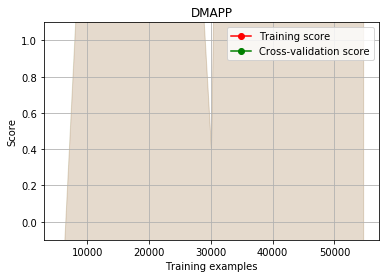

Target: DMAPP, CV Pearson R2 coefficient: -0.321575
GPP


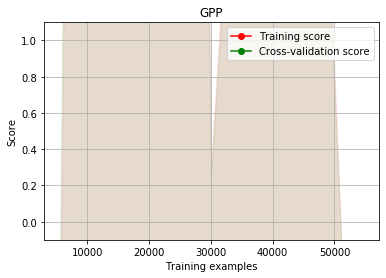

Target: GPP, CV Pearson R2 coefficient: -0.428996
Limonene


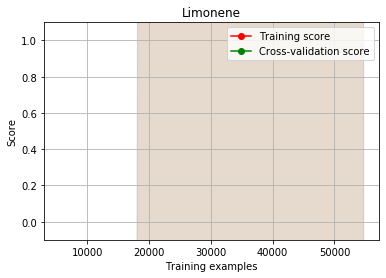

Target: Limonene, CV Pearson R2 coefficient: -51.428655
Average training score: -31.407345669912996
Elapsed time:  745.443253993988


In [20]:
# TODO: call the train_data function to train a neural network model (may take ~15 mins to compute)
import time

t0 = time.time()

model_type = 'neural_network'
nn_dict, score_dict = train_data(ml_train, nn_model, plot=True,model_type=model_type) # YOUR CODE HERE

t1 = time.time()
print("Elapsed time: ", t1-t0)

Acetyl-CoA


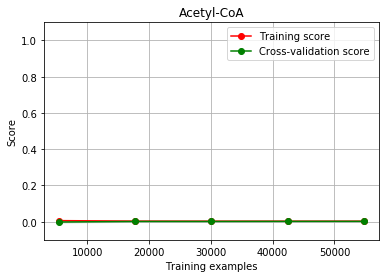

Target: Acetyl-CoA, CV Pearson R2 coefficient: 0.002781
Acetoacetyl-CoA


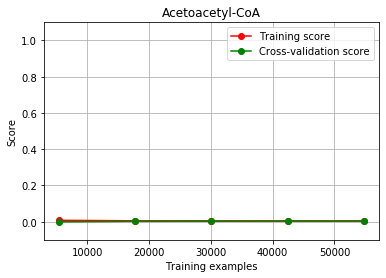

Target: Acetoacetyl-CoA, CV Pearson R2 coefficient: 0.004194
HMG-CoA


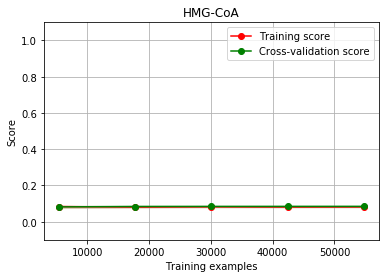

Target: HMG-CoA, CV Pearson R2 coefficient: 0.081455
Mev


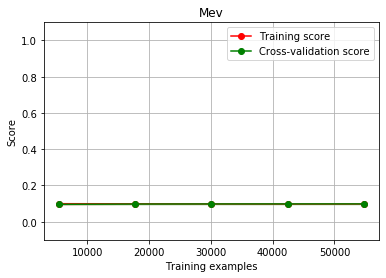

Target: Mev, CV Pearson R2 coefficient: 0.097699
MevP


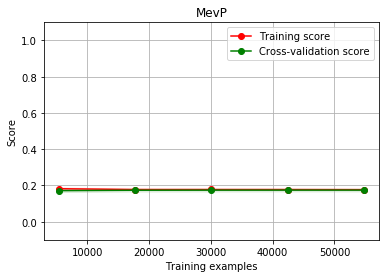

Target: MevP, CV Pearson R2 coefficient: 0.176725
MevPP


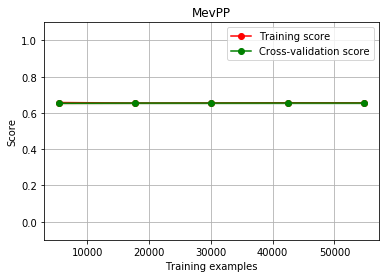

Target: MevPP, CV Pearson R2 coefficient: 0.655747
IPP


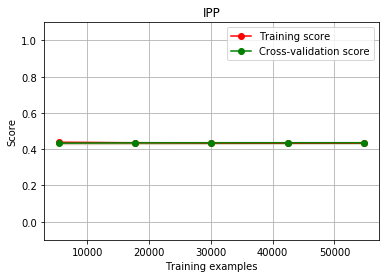

Target: IPP, CV Pearson R2 coefficient: 0.433513
DMAPP


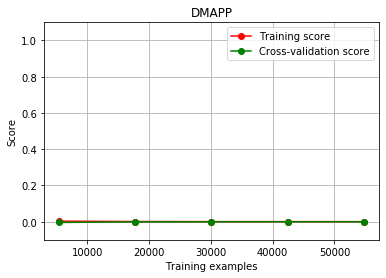

Target: DMAPP, CV Pearson R2 coefficient: 0.000196
GPP


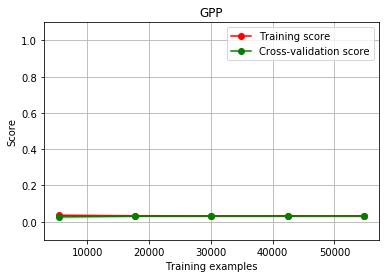

Target: GPP, CV Pearson R2 coefficient: 0.032211
Limonene


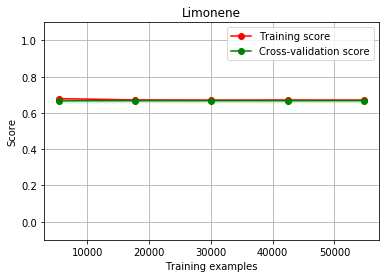

Target: Limonene, CV Pearson R2 coefficient: 0.670874
Average training score: 0.2155394455049441
Elapsed time:  393.0353808403015


In [13]:
# TODO: call the train_data function to train a linear regression model (may take ~15 mins to compute)

import time

t0 = time.time()

model_type = 'linear_regression'
lr_dict, score_dict = train_data(ml_train, lr_model, plot=True,model_type=model_type) # YOUR CODE HERE

t1 = time.time()
print("Elapsed time: ", t1-t0)


32.51 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesRegressor(input_matrix, bootstrap=True, max_features=0.45, min_samples_leaf=3, min_samples_split=17, n_estimators=100)
Acetyl-CoA


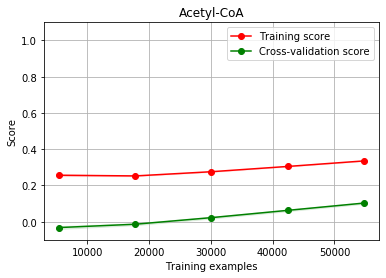

Target: Acetyl-CoA, CV Pearson R2 coefficient: 0.349811



34.33 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesRegressor(KNeighborsRegressor(input_matrix, n_neighbors=26, p=2, weights=distance), bootstrap=False, max_features=0.7000000000000001, min_samples_leaf=6, min_samples_split=5, n_estimators=100)
Acetoacetyl-CoA


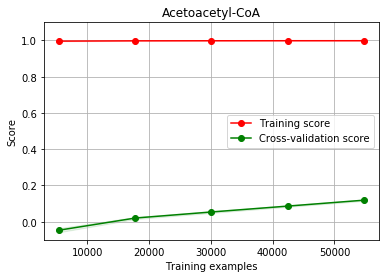

Target: Acetoacetyl-CoA, CV Pearson R2 coefficient: 0.998761



33.05 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: KNeighborsRegressor(input_matrix, n_neighbors=1, p=2, weights=uniform)
HMG-CoA


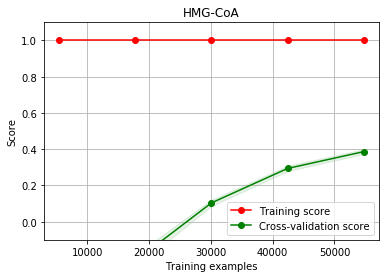

Target: HMG-CoA, CV Pearson R2 coefficient: 1.000000



30.99 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: KNeighborsRegressor(LassoLarsCV(input_matrix, normalize=True), n_neighbors=20, p=1, weights=distance)


/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22

/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22

Mev


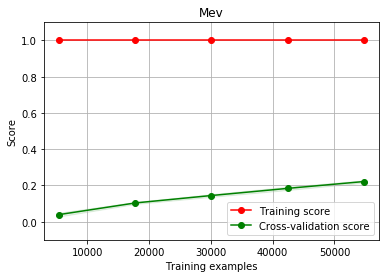

Target: Mev, CV Pearson R2 coefficient: 1.000000



33.79 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: KNeighborsRegressor(input_matrix, n_neighbors=32, p=2, weights=distance)
MevP


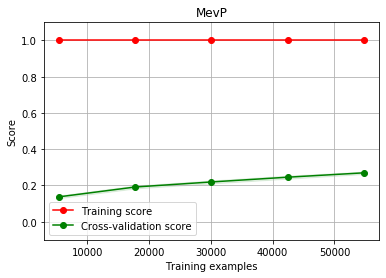

Target: MevP, CV Pearson R2 coefficient: 1.000000



30.02 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: AdaBoostRegressor(input_matrix, learning_rate=0.5, loss=exponential, n_estimators=100)
MevPP


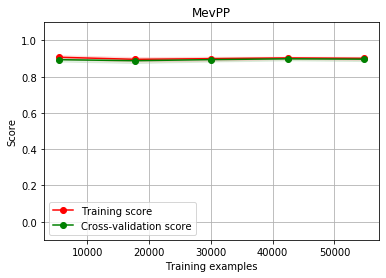

Target: MevPP, CV Pearson R2 coefficient: 0.887762



32.31 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestRegressor(CombineDFs(input_matrix, input_matrix), bootstrap=True, max_features=0.15000000000000002, min_samples_leaf=5, min_samples_split=16, n_estimators=100)


/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/ana

/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/ana

/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/ana

/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/ana

/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/ana

/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/ana

/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/ana

/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/ana

/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/ana

/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/ana

/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/ana

IPP


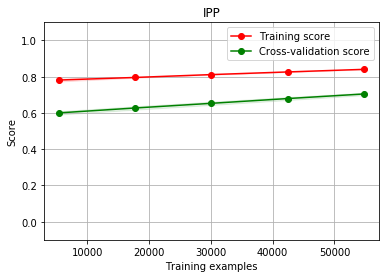

/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


Target: IPP, CV Pearson R2 coefficient: 0.847681



30.98 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: KNeighborsRegressor(input_matrix, n_neighbors=4, p=1, weights=distance)
DMAPP


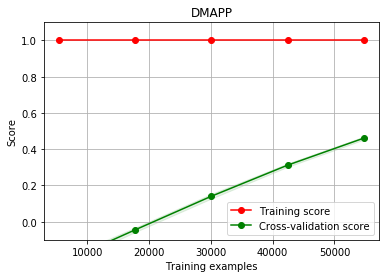

Target: DMAPP, CV Pearson R2 coefficient: 1.000000



30.75 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: KNeighborsRegressor(input_matrix, n_neighbors=7, p=1, weights=distance)
GPP


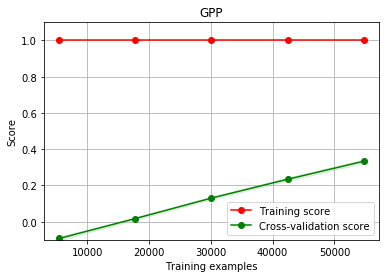

Target: GPP, CV Pearson R2 coefficient: 1.000000


Generation 1 - Current best internal CV score: -1.2619898636336994e-08

30.13 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: KNeighborsRegressor(MinMaxScaler(input_matrix), n_neighbors=4, p=1, weights=distance)
Limonene


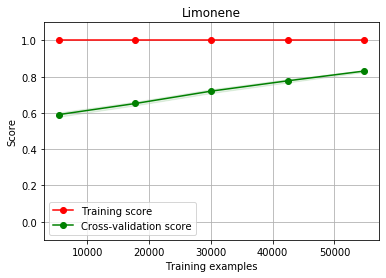

Target: Limonene, CV Pearson R2 coefficient: 1.000000
Average training score: 0.9084014294610565
Elapsed time:  21029.996860980988


In [24]:
# TODO: call the train_data function to train an automated TPOT model
# (warning, this may take several hours! skip this and come back later if needed after you finish the other sections)

import time

t0 = time.time()

model_type = 'tpot'
tpot_dict, score_dict = train_data(ml_train, tpot_model, plot=True,model_type=model_type) # YOUR CODE HERE

t1 = time.time()
print("Elapsed time: ", t1-t0)

**Questions**:
1. You may have noticed that random forest performs poorly for predicting Limonene, but shows OK performance for predicting other metabolites. Why do you think this is so?
2. Try to improve the performance of the neural network by doing some hyperparameter tuning (e.g. reducing the number of hidden layers).

In [14]:
# TODO: complete the function to compute RMSE error for every metabolite and the total RMSE
# make sure that the directory specified in figure_path exists! otherwise the execution will return an error.
import math

figure_path = './plots/'

def compute_error(data,model_dict,plot=False,model_type=None):
    
    """
    To check the error of predicted derivative.
    
    Arguments:
    
    data -- time-series data of measurements, preprocessed by interpolating and filtering
    model_dict -- a dictionary of trained models or each target
    plot -- decide to plot the result or not
    model_type -- determine the input model
    
    """
    
    # list of errors
    # this contains the error for every metabolite (target)
    error_list = []

    for target in model_dict:
        # Extract input target
        y_test = data[('target',target)].values
    
        # Extract predicted target
        feature_list = [('feature',feature) for feature in data['feature'].columns]
        target_data = data[feature_list]
        y_prediction = model_dict[target].predict(target_data.values)
    
        # TODO: Compute squared error and append it to the list of errors
        ## YOUR CODE HERE
        error = [y_p - y_t for y_p,y_t in zip(y_prediction,y_test)]
        error_list.append(error)
        
        # Compute mean and standard deviation of squared error
        ## YOUR CODE HERE
        mu = np.mean(error)
        sigma = np.std(error)
        print(target,'RMSE:',mu,'standard deviation:',sigma)
        
        if plot:
            plt.figure(figsize=(13,4))
            plt.subplot(121)
            sns.distplot(error)
            
            plt.title(target + ' Derivative '+ 'Error Residual Histogram')
            plt.xlabel('Derivative Residual Error')
            plt.ylabel('Probability Density')
    
            plt.subplot(122)
            error_plot(target,y_prediction,y_test) # this function is provided below
    
            strip_target = ''.join([char for char in target if char != '/'])
            plt.savefig(figure_path + strip_target +'_'+ model_type + '_Error_Residuals.pdf')
            plt.show()

    # TODO: compute total error from the error list
    ## YOUR CODE HERE
    error_magnitude = [0]*len(error_list[0])

    for error in error_list:
        error_magnitude = [em + e**2 for em,e in zip(error_magnitude,error)]
        error_magnitude = [math.sqrt(e) for e in error_magnitude]

    mu = np.mean(error_magnitude)
    sigma = np.std(error_magnitude)
    print('Total Derivative','Mean Error:',mu,'Error Standard Deviation:',sigma)
    
    if plot:
        sns.distplot(error_magnitude)
        plt.title('Total Derivative Error Histogram')
        plt.show()

In [15]:
# the function error plot is provided to you below.

def error_plot(name,pred,real):
    
    """
    Generate a plot from detecting error of derivatives.

    Arguements:
    
    name -- a name for the title.
    pred -- a list of predicted derivatives
    real -- a list of actual derivatives
    
    """

    plt.scatter(pred,real)
    plt.title(name + ' Predicted vs. Actual')
    
    axis = plt.gca()
    axis.plot([-120,120], [-120,120], ls="--", c=".3")
    
    padding_y = (max(real) - min(real))*0.1
    plt.ylim(min(real)-padding_y,max(real)+padding_y)
    
    padding_x = (max(pred) - min(pred))*0.1
    plt.xlim(min(pred)-padding_x,max(pred)+padding_x)
    
    plt.xlabel('Predicted ' + name)
    plt.ylabel('Actual ' + name)
 

Acetyl-CoA RMSE: -3.317202834750388e-06 standard deviation: 0.001801219730383221


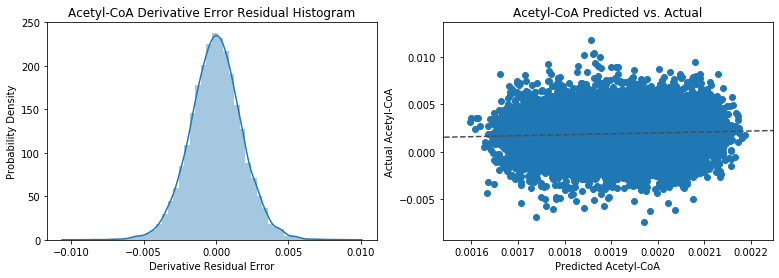

Acetoacetyl-CoA RMSE: -1.788510609105352e-06 standard deviation: 0.0013720735560282206


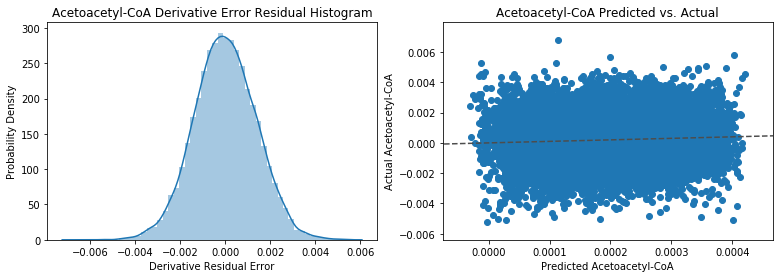

HMG-CoA RMSE: -1.643172410744807e-06 standard deviation: 0.0011829146666998663


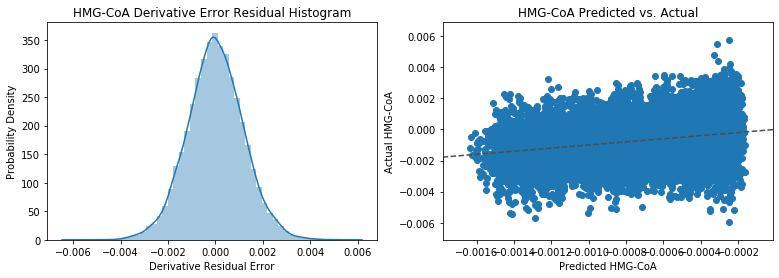

Mev RMSE: -3.1210094643410048e-06 standard deviation: 0.0013861332384278273


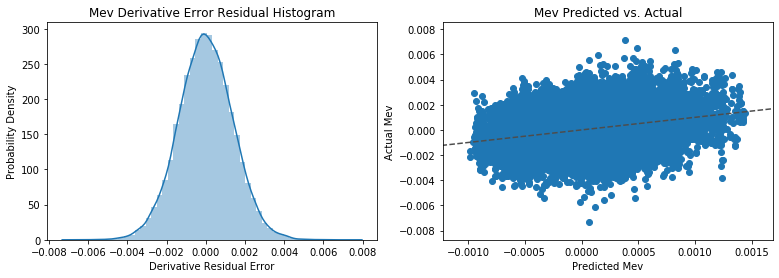

MevP RMSE: -3.464335845506692e-06 standard deviation: 0.0012364335686955313


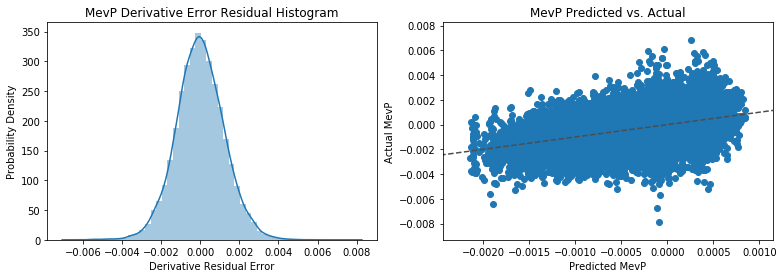

MevPP RMSE: -9.998819797409822e-05 standard deviation: 0.002124314704904573


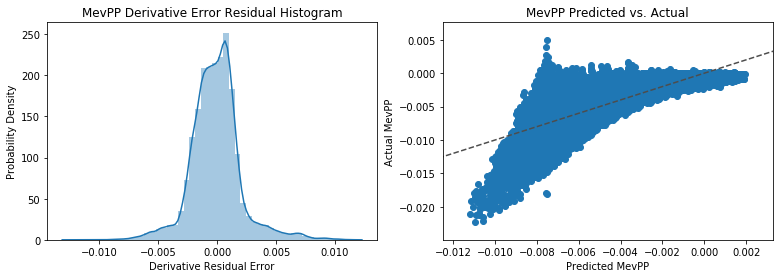

IPP RMSE: 0.00010779266879509031 standard deviation: 0.0033376659631667582


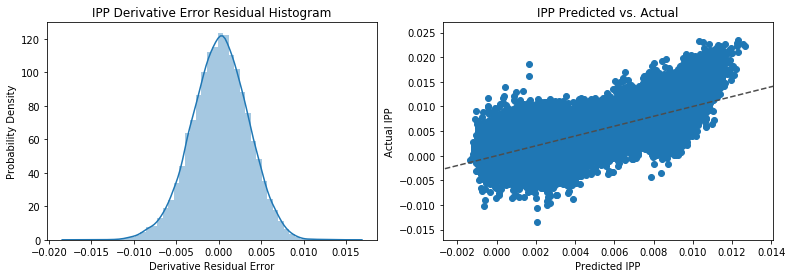

DMAPP RMSE: 1.2113717815162007e-06 standard deviation: 0.0013611626258330967


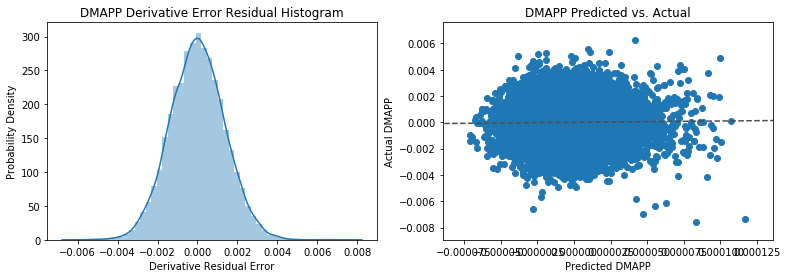

GPP RMSE: -7.536329237524475e-06 standard deviation: 0.0012464674121073752


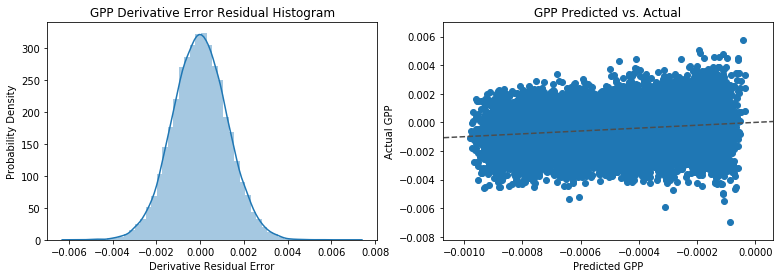

Limonene RMSE: 2.821702325278855e-06 standard deviation: 0.00014364797784568496


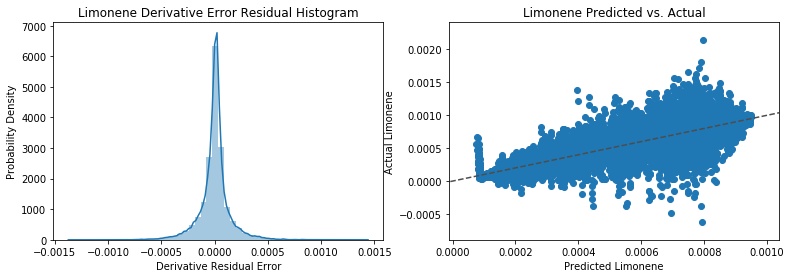

Total Derivative Mean Error: 0.9864285583336059 Error Standard Deviation: 0.002159632106606299


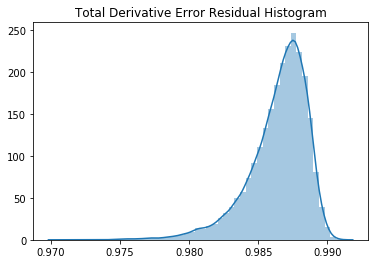

In [31]:
## TODO: call the compute error function for the random forest model,
# using the test data and also training (in-sample) data

compute_error(ml_test,rf_dict,plot=True,model_type='random_forest')

Acetyl-CoA RMSE: -2.0639444852556207e-06 standard deviation: 0.001801198238802286


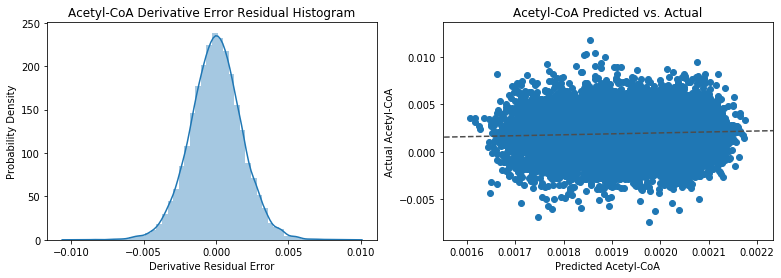

Acetoacetyl-CoA RMSE: -2.9064904847540413e-06 standard deviation: 0.0013720423844345174


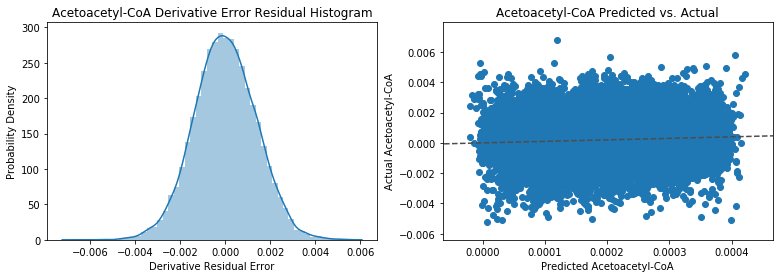

HMG-CoA RMSE: -2.0147333855102046e-06 standard deviation: 0.0011829380124137026


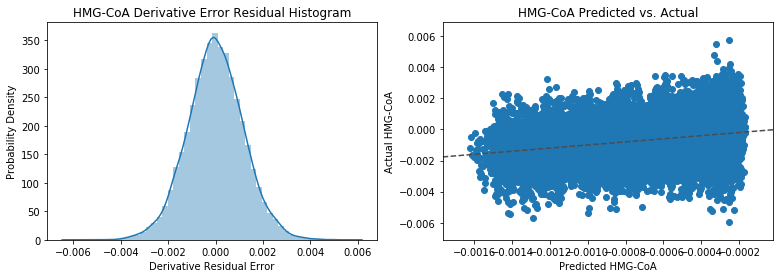

Mev RMSE: -2.6418144467163023e-06 standard deviation: 0.0013861889079819847


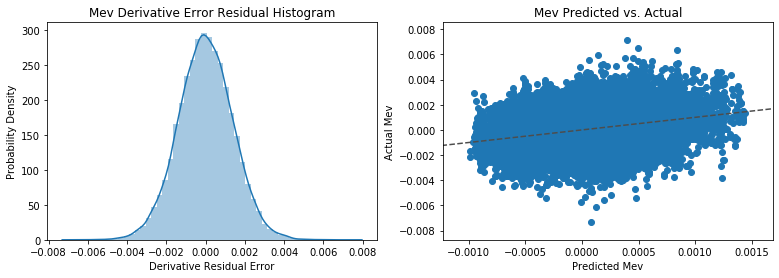

MevP RMSE: -3.688584447598893e-06 standard deviation: 0.0012364785360774032


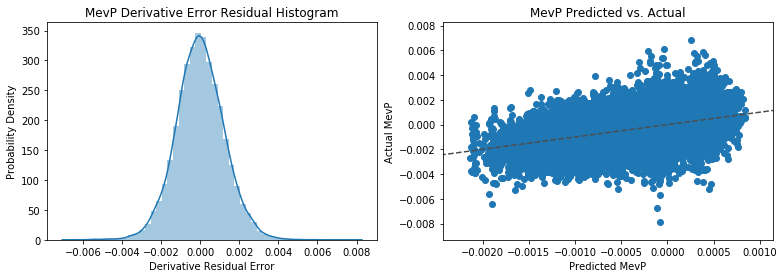

MevPP RMSE: -0.00010173933291872332 standard deviation: 0.002124247363402391


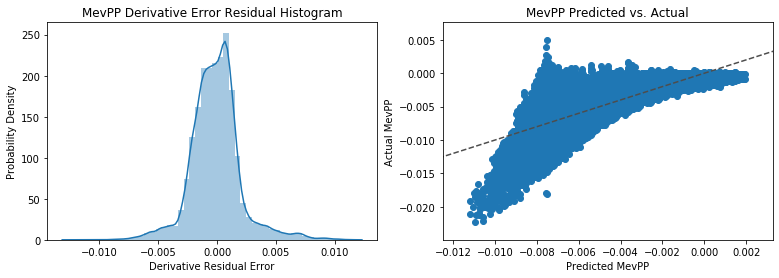

IPP RMSE: 0.00011013640578201356 standard deviation: 0.0033378283240290854


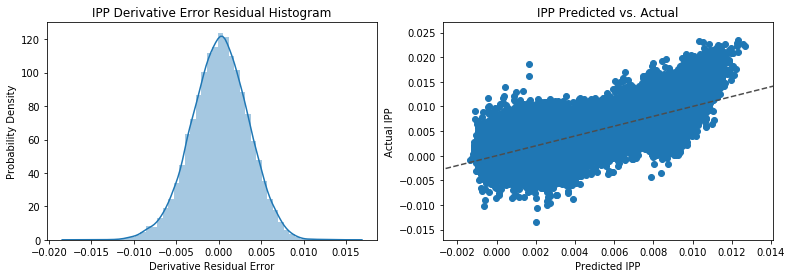

DMAPP RMSE: 1.4306682665752199e-06 standard deviation: 0.001361161771549329


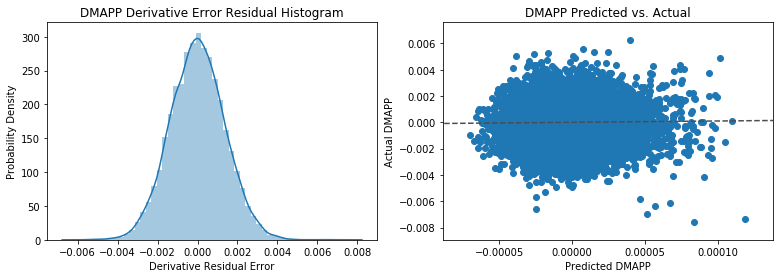

GPP RMSE: -5.910761346950014e-06 standard deviation: 0.001246474745095665


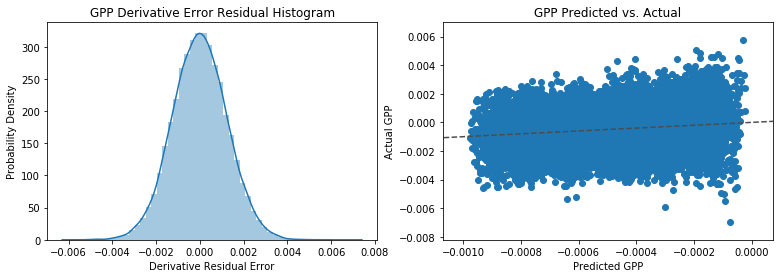

Limonene RMSE: 2.6142951444757736e-06 standard deviation: 0.00014364964626282847


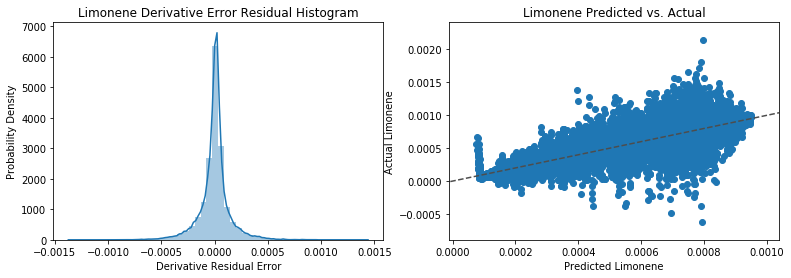

Total Derivative Mean Error: 0.9864283261082226 Error Standard Deviation: 0.00216304434723869


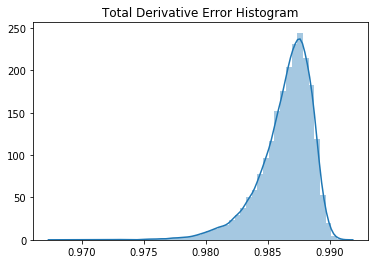

In [16]:
## TODO: call the compute error function for the neural network model,
# the linear regression model
# using the test data and also training (in-sample) data

compute_error(ml_test,lr_dict,plot=True,model_type='linear_regression')

Acetyl-CoA RMSE: 1.2268059367191955e-05 standard deviation: 0.001804575217208927


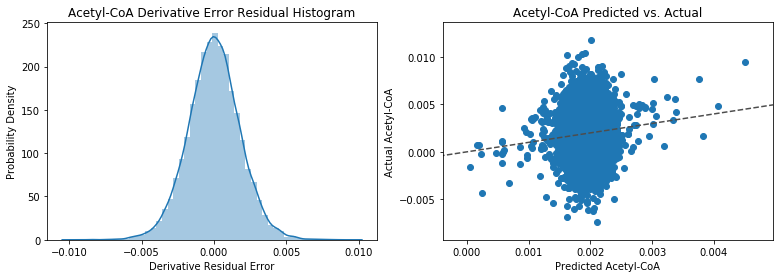

Acetoacetyl-CoA RMSE: -6.951121681964762e-06 standard deviation: 0.0013970160774502808


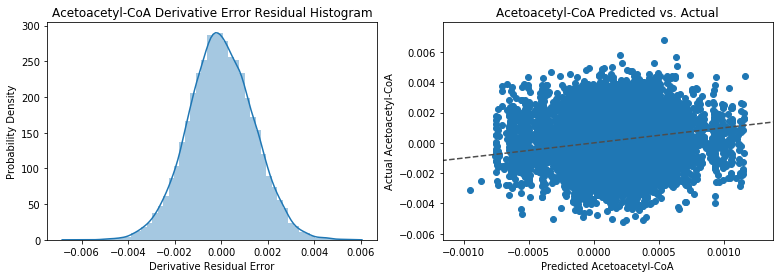

HMG-CoA RMSE: -8.802991516493538e-05 standard deviation: 0.001761186808561878


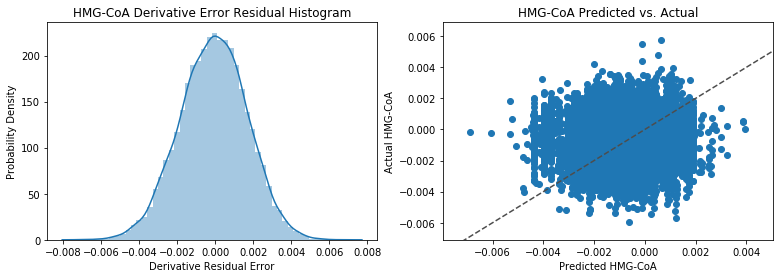

Mev RMSE: 5.092613983236369e-05 standard deviation: 0.0014493588870960633


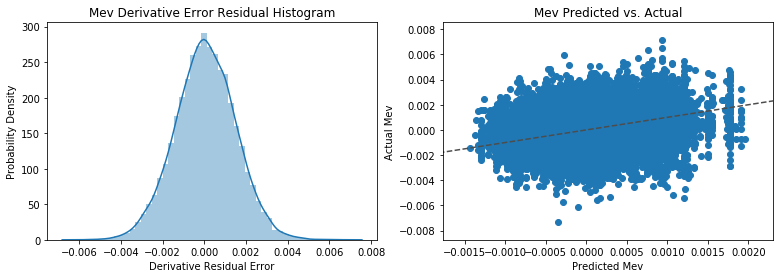

MevP RMSE: -0.00010811113606360715 standard deviation: 0.0013040839611316681


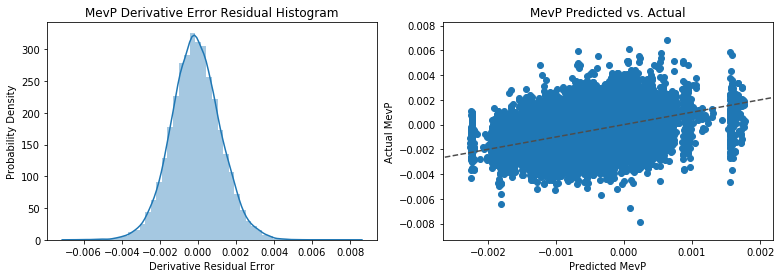

MevPP RMSE: -0.0007172535557523587 standard deviation: 0.0009399466963120395


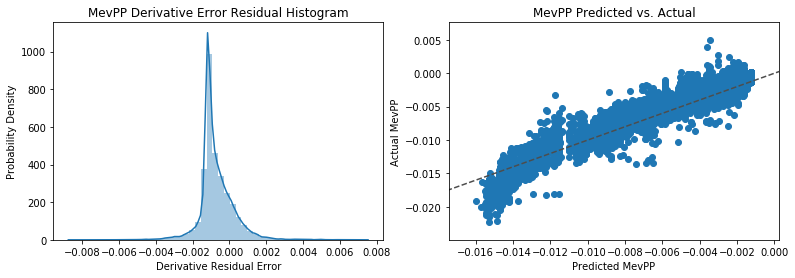

/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


IPP RMSE: 0.00010365645421497318 standard deviation: 0.002678491207203424


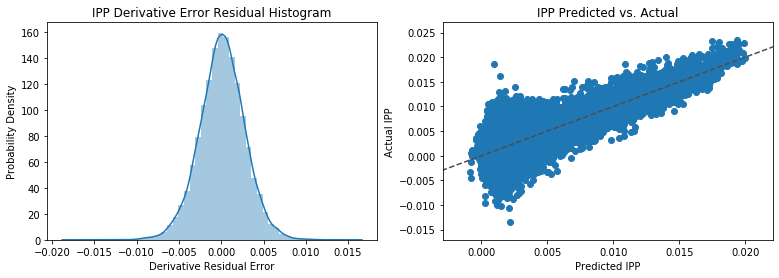

DMAPP RMSE: -0.00012910963153082666 standard deviation: 0.001653314126257677


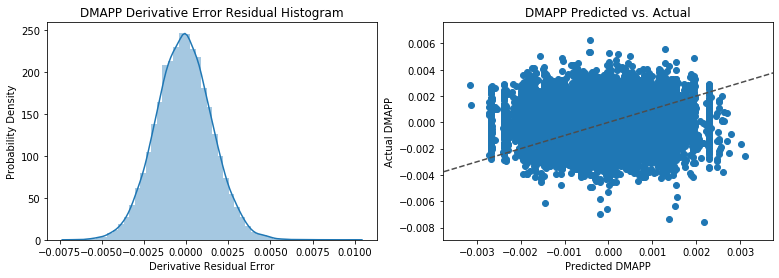

GPP RMSE: 7.90143644448558e-06 standard deviation: 0.001427423965023367


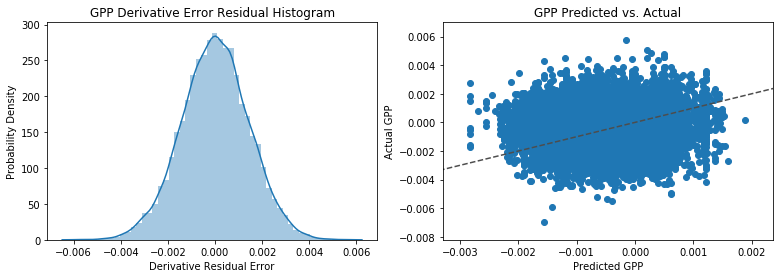

Limonene RMSE: 2.031118416126552e-05 standard deviation: 0.00020202050994215596


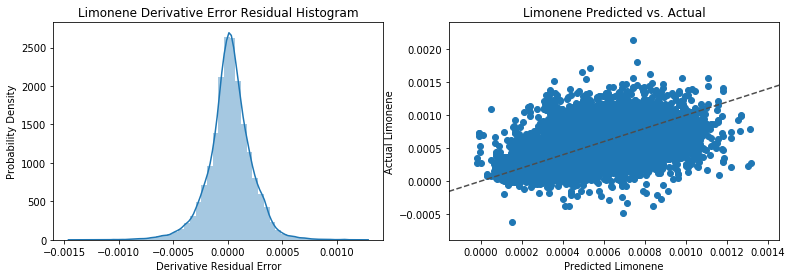

Total Derivative Mean Error: 0.9864388983001771 Error Standard Deviation: 0.002141151526739116


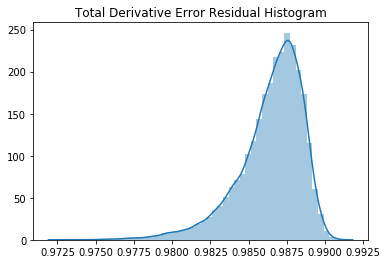

In [34]:
## TODO: call the compute error function for the tpot model
# using the test data and also training (in-sample) data

compute_error(ml_test,tpot_dict,plot=True,model_type='tpot')

Next, we are going to use this trained model to make predictions. To do that, we will solve the initial value problem by numerical integration. The function for solving the IVP is provided for you. The general idea is:
1. Create the derivative function from the learned model
2. solve the IVP with the derivative function and initial conditions

Below, you will find two functions:
1. `int_ode(...)` for solving the initial value problem
2. `ml_ode(...)` for defining the derivative dynamics learned by machine learning (representing the 'ODE equation'). This function will be passed to the `int_ode` function to be integrated.

**Your task** is to apply the provided functions `ml_ode(...)` to integrate the dynamics. In our setting, the function that describes the dynamics of the metabolites $f(m,p) = \dot{m}$ takes the protein concentrations as given.

In [44]:
# you are provided with the function to integrate below
from scipy.integrate import ode

def int_ode(g,y0,times,solver='scipy'):
    
    """
    Integration function corresponded to the ode, generated by ml_ode.
    
    Arguments:
    f -- an ode equation to be integrated
    y0 -- an initial condition as a list of concentrations
    times -- a list of time coordinate
    solver -- string of package used for ode solver
    
    Return:
    x -- a solution of the ode problem
    
    """
    
    if solver == 'assimulo':
        from assimulo.problem import Explicit_Problem
        from assimulo.solvers import Dopri5
        
        # Set up ODE
        rhs = lambda t,x: g(x,t)
        model = Explicit_Problem(rhs,y0,min(times))
        sim = Dopri5(model)
        
        # Preform integration
        _,x = sim.simulate(max(times),max(times))
        return np.array(x)[np.array(times).astype(int)].tolist()
    
    elif solver == 'scipy':
        # Set up ODE
        f = lambda t,x: g(x,t)
        r = ode(f).set_integrator('dopri5',
                                  nsteps=1e4,
                                  atol=1e-3)
    
        r.set_initial_value(y0,times[0])
    
        #widgets.FloatProgress(min=0, max=max(times))
    
        # Preform integration
        x = [y0,]
        currentT = times[0]
        max_delT = 10
    
        for nextT in times[1:]:
        
            while r.t < nextT:
            
                if nextT-currentT < max_delT:
                    dt = nextT-currentT
                else:
                    dt = max_delT
                
                value = r.integrate(r.t + dt)
                currentT = r.t

                f.value = currentT
            
            x.append(value)
        return x

In [39]:
# you are provided with the function to define the derivatives below

def ml_ode(model_dict, data, targets, features, time_index='Hour'):
    
    """
    Set up an ODE.
    
    Arguments:
    model_type -- a string for desired model
    data -- raw time-series data of measurements
    targets -- list of targets
    features -- list of features
    time_index -- a string labelel for time index of the input data
    
    Return:
    f - an output ODE
    
    """
    
    # Create interpolations for each feature
    ml_interpolation = {}
    
    for feature in data.columns:
        feature_columns = feature
        
        if isinstance(feature,tuple):
            if feature[0]=='feature':
                feature = feature[1]
            else:
                continue

        if feature in features:    
            X,y = data.reset_index()[time_index].tolist(), data[feature_columns].tolist()

            ml_interpolation[feature] = interp1d(X,y)
            
    # Define the function to be integrated
    def f(x,t):
        x_dot = []
        
        # Create derivatives for each target
        for target in targets:
            x_pred = []
            
            # loop over all species
            for feature in data.columns:
                if isinstance(feature,tuple):
                    if feature[0]=='feature':
                        feature = feature[1]
                    else:
                        continue
                
                if feature in features:
                    x_pred = np.append(x_pred, ml_interpolation[feature](t))
                elif feature in targets:
                    x_pred = np.append(x_pred, x[targets.index(feature)])
                
            model_prediction = model_dict[target].predict(x_pred.reshape(1,-1))
            x_dot = np.append(x_dot,model_prediction)   
            
        return x_dot
    return f

In [53]:
# TODO: write a function to integrate the dynamics and predict time points
import random
from scipy.integrate import quad
figure_path = './plots/'

def predict_integrate(ts_data,tr_data,model_dict,targets,features,pathway,
              plot=False,model_type=None,solver='scipy'):
    
    """
    Integrate the learned 'ODE' and use it for simulations
    
    Arguments:
    
    tr_data -- raw time-series data of measurements used for training
    ts_data -- raw time-series data of measurements used for testing
    model_dict -- a dictionary of trained models or each target
    pathway -- a selected pathway
    targets -- list of targets
    features -- list of features
    plot -- decide to plot the result or not
    model_type -- determine the input model
    solver -- string of package used for ode solver
    
    """
    
    rmse_average = []
    rmse_percent = []
    
    ts = ts_data 
    
    # Get a randomed strain
    strains = ts.index.get_level_values(0).unique().tolist()
    strain = random.sample(strains,1)
    
    test_data = ts.loc[strain]
        
    # TODO: get the initial conditions from test_data
    y0 = test_data[targets].iloc[0].tolist()
    
    # TODO: call ml_ode function to construct the 'ODE'
    g = ml_ode(model_dict, 
               test_data, 
               targets, 
               features, 
               time_index='Hour')

    # Get the time points
    times = test_data.reset_index()['Hour'].tolist()
        
    # TODO: call int_ode to integrate the 'ODE' g
    fit = int_ode(g,y0,times,solver=solver)
        
    # Format the output as a table
    fit_data = pd.DataFrame(fit, 
                            index=times, 
                            columns = targets).rename_axis('Hour')
    
    # Set up real data and predicted targets
    real = test_data[targets]
    pred = fit_data
        
    # Display them
    print('Real data:')
    display(real)
    print('Predicted data:')
    display(pred)
        
        
    for metabolite in fit_data.columns:
        t,X = times, real[metabolite].tolist()
        real_fcn = interp1d(t,X)
        pred_fcn = interp1d(times,pred[metabolite])
            
        '''
        Optional 
        times =  real[metabolite].dropna().index.tolist()
        real_fcn = interp1d(times,real[metabolite].dropna())
        pred_fcn = interp1d(times,pred[metabolite].loc[times])
        '''
            
        # Calculate RMSE average
        integrand = lambda t: (real_fcn(t) - pred_fcn(t))**2
        rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
        rmse_average.append(rmse)
            
         # Calculate RMSE percentage
        percent_integrand = lambda t: abs(real_fcn(t) - pred_fcn(t))/(real_fcn(t)*max(times))
        rmsep = math.sqrt(quad(percent_integrand,min(times),max(times),limit=200)[0])
        rmse_percent.append(rmsep)
        
        print('ML Fit:',metabolite,rmse,
              'RMSE percentage:',rmsep*100)
    
    print('ML model aggregate error')
    print('Average RMSE:',sum(rmse_average)/len(rmse_average))
    print('Total percentage error:',sum(rmse_percent)/len(rmse_percent)*100)
        
    if plot:
        tr = tr_data
        fitT = list(map(list, zip(*fit)))
        
        # Create interpolation functions for each feature
        interp_f = {}
            
        for feature in test_data.columns:
            t,X = test_data.reset_index()['Hour'].tolist(), test_data[feature].tolist()
            interp_f[feature] = interp1d(t,X)
        
        plt.figure(figsize=(12,8))
        
        common_targets = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA','Mev','IPP', 'Limonene']
        for i,target in enumerate(common_targets):
            plt.subplot(2,3,i+1)
            
            for strain in tr_strains:
                strain_interp_f = {}
                strain_df = tr.loc[strain]
                
                X,y = strain_df.reset_index()['Hour'].tolist(), strain_df[target].tolist()
                strain_interp_f[target] = interp1d(X,y)
                
                actual_data = [strain_interp_f[target](t) for t in times]
                
                train_line, = plt.plot(times,actual_data,'r--')
                    
            actual_data = [interp_f[target](t) for t in times]
            
            pos_pred = [max(fitT[i][j],0) for j,t in enumerate(times)]
            prediction_line, = plt.plot(times,pos_pred)
            
            test_line, = plt.plot(times,actual_data,'g--')
            
            plt.ylabel(target)
            plt.xlabel('Time [h]')
            plt.xlim([0,72])
    
        if pathway=='isopentenol':
            product = 'Isopentenol'
        elif pathway=='limonene':
            product = 'Limonene'
    
        plt.tight_layout()
        plt.subplots_adjust(top=0.90)
        plt.subplots_adjust(bottom=0.12)
        plt.suptitle('Prediction of ' + product + ' Strain Dynamics', fontsize=18)
        plt.figlegend((train_line,test_line,prediction_line), 
                      ('Training Set Data','Test Data','Machine Learning Model Prediction'), 
                      loc = 'lower center', ncol=5, labelspacing=0. ) 
            
        plt.savefig(figure_path + product + model_type +'_prediction.eps', format='eps', dpi=600)
        plt.show()

Real data:


Acetyl-CoA  Acetoacetyl-CoA   HMG-CoA       Mev      MevP     MevPP  \
Strain                                                                        
8696      0.200344         0.199516  0.200147  0.197739  0.199143  0.198036   
8696      0.202649         0.201052  0.201030  0.200074  0.200205  0.196033   
8696      0.203628         0.203154  0.198416  0.200762  0.200789  0.187308   
8696      0.207535         0.202246  0.196149  0.201789  0.198967  0.179344   
8696      0.208901         0.200095  0.199151  0.203068  0.197947  0.173069   
...            ...              ...       ...       ...       ...       ...   
8696      0.331619         0.205741  0.140497  0.244516  0.139072  0.015309   
8696      0.334219         0.205190  0.139125  0.249206  0.136299  0.014943   
8696      0.342924         0.207872  0.138322  0.250357  0.137068  0.014681   
8696      0.344438         0.203167  0.138882  0.245423  0.135542  0.014388   
8696      0.346664         0.203124  0.138033  0.251340  0.136217  0.014355   

             IPP     DMAPP       GPP  Limonene  
Strain                                          
8696    0.200540  0.201482  0.201172  0.000000  
8696    0.206933  0.198512  0.200327  0.000366  
8696    0.215160  0.200323  0.201766  0.000818  
8696    0.223903  0.200219  0.198464  0.001284  
8696    0.229478  0.201025  0.198427  0.001746  
...          ...       ...       ...       ...  
8696    0.463255  0.198874  0.170208  0.029794  
8696    0.469524  0.201857  0.171152  0.030398  
8696    0.461325  0.200268  0.167680  0.030491  
8696    0.464110  0.202334  0.169150  0.031120  
8696    0.460829  0.198935  0.168945  0.031229  

[72 rows x 10 columns]

Predicted data:


Acetyl-CoA  Acetoacetyl-CoA       HMG-CoA           Mev          MevP  \
Hour                                                                            
0     2.003437e-01     1.995158e-01  2.001467e-01  1.977386e-01  1.991427e-01   
1    -3.382001e+04     6.821009e+03  2.098006e+04  1.854446e+04  2.819246e+04   
2    -1.091810e+05     2.288358e+04  6.919507e+04  5.638810e+04  9.143652e+04   
3    -1.956619e+05     4.237022e+04  1.262994e+05  9.553871e+04  1.645243e+05   
4    -2.874583e+05     6.341793e+04  1.878919e+05  1.352076e+05  2.423154e+05   
...            ...              ...           ...           ...           ...   
67   -4.983264e+06     1.450210e+06  4.607385e+06  1.325046e+06  5.667283e+06   
68   -4.994930e+06     1.468428e+06  4.662503e+06  1.292687e+06  5.755497e+06   
69   -5.003600e+06     1.486537e+06  4.716915e+06  1.257261e+06  5.845036e+06   
70   -5.008902e+06     1.504530e+06  4.770221e+06  1.219168e+06  5.934384e+06   
71   -5.010228e+06     1.522228e+06  4.821751e+06  1.178548e+06  6.022436e+06   

             MevPP           IPP         DMAPP           GPP      Limonene  
Hour                                                                        
0     1.980362e-01  2.005396e-01  2.014823e-01  2.011723e-01  0.000000e+00  
1    -4.985032e+03  6.782732e+04  7.585141e+03 -2.201382e+04 -9.895659e+03  
2    -1.024136e+04  2.121324e+05  2.343406e+04 -6.983220e+04 -3.162631e+04  
3    -8.933609e+03  3.693926e+05  4.047828e+04 -1.232071e+05 -5.630772e+04  
4    -3.715648e+03  5.322363e+05  5.828336e+04 -1.794417e+05 -8.244251e+04  
...            ...           ...           ...           ...           ...  
67    4.375043e+06  6.774095e+06  2.087084e+06 -4.726988e+06 -1.894530e+06  
68    4.518248e+06  6.751208e+06  2.134089e+06 -4.806872e+06 -1.922455e+06  
69    4.664655e+06  6.722774e+06  2.181411e+06 -4.886990e+06 -1.950526e+06  
70    4.814465e+06  6.688297e+06  2.229268e+06 -4.967235e+06 -1.978419e+06  
71    4.967227e+06  6.647513e+06  2.277835e+06 -5.047241e+06 -2.006064e+06  

[72 rows x 10 columns]

/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


ML Fit: Acetyl-CoA 28775277.97577522 RMSE percentage: 323096.3187417921
ML Fit: Acetoacetyl-CoA 7619980.77258238 RMSE percentage: 196084.94491634748
ML Fit: HMG-CoA 24028698.04406941 RMSE percentage: 397444.9953795816
ML Fit: Mev 9645780.199105958 RMSE percentage: 212043.80793060645
ML Fit: MevP 28937710.073755603 RMSE percentage: 438091.0240509921
ML Fit: MevPP 18293607.233993232 RMSE percentage: 893655.3369151438
ML Fit: IPP 42076574.719856344 RMSE percentage: 332112.6335347028
ML Fit: DMAPP 9719261.15498976 RMSE percentage: 217116.84823004843
ML Fit: GPP 23510687.146729402 RMSE percentage: 364320.990885643


/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


ML Fit: Limonene 9724603.427260786 RMSE percentage: 768048.3255682917
ML model aggregate error
Average RMSE: 20233218.07481181
Total percentage error: 414201.5226153149


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


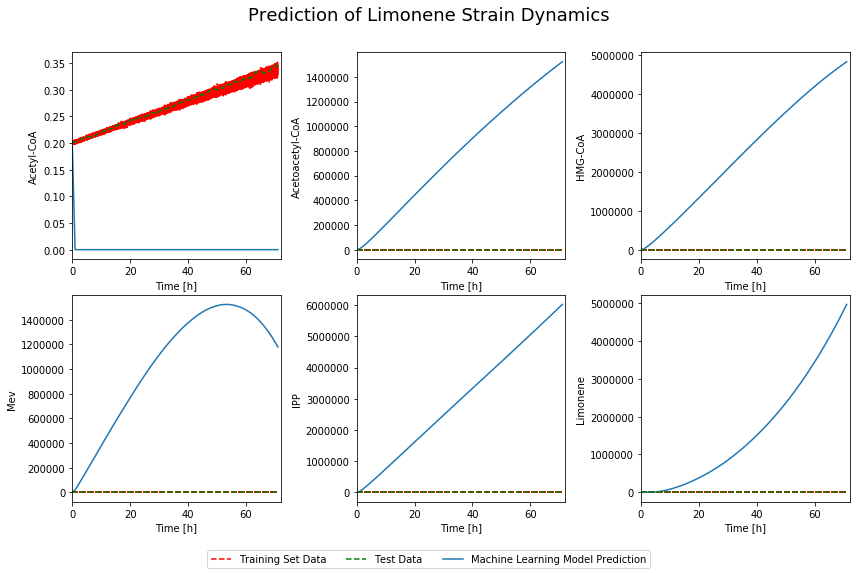

In [55]:
# TODO: call the function predict_integrate to integrate dynamics and make predictions
predict_integrate(test_data,train_data,lr_dict,targets,features,'limonene',plot=True,model_type='linear_regression')

Congratulations! Now you have seen how machine learning can be used for empirical dynamic modeling in systems biology. Next, you can explore other ways to use what you have For example, you can use the learned model to make simulations and explore the metabolomics/proteomics phase space. You can gain further insights, e.g. by performing PCA and visualizing the simulations in 2-D principal components phase space.